## This Notebook is to find solution for imbalanced NLP data.
## Using pre-trained word embedding Word2Vec, apply the Ensemble Random Forest algorithm to fit the train data; then using validation data for prediction. Chosing Random Forest is because it can handle imbalanced data. The train accuracy reached 0.91, validation accuracy 0.77.

## Applied SMOTE oversampling technique for minority classes, train acc reached 0.94, validation acc 0.75.

## Applied Cost-Sensitive Learning for Multi-Class Classification. 

## Data is downloaded from this public GitHub repo:

https://github.com/MarletteFunding/marlette-ds-challenge2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Upload data from Google Drive

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
path='/content/drive/My Drive/Data_Sets/'
df_train = pd.read_csv(path+'NLP_task_train.csv.zip',header=0,index_col=0,compression='infer')
df_validate = pd.read_csv(path+'NLP_task_validate.csv.zip',header=0,index_col=0,compression='infer')

## Explore the data, Visulization target (Scores), handle missing data

In [3]:
df_train.head()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
0,583306034,1888104,The whole process went smooth and I am thankfu...,109,165,10.0
1,583306034,1888102,It was quick and easy to apply and got the app...,0,60,10.0
2,584193040,1909902,service,0,7,10.0
3,584203035,1910310,Thanks!,198,205,10.0
4,584200037,1910006,Thank you!,58,68,10.0


In [4]:
df_train.tail()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
70657,689569033,3973028,good communication on each step,25,56,8.0
70659,689548036,3972918,Applying for this loan was a very easy experience,0,49,10.0
70660,689549033,3973010,Was very helpful and stayed on phone to make s...,0,103,10.0
70661,689564034,3973230,High Interest Rates,0,19,8.0
70662,689550033,3973221,I appreciate this loan opportunity from Best E...,63,120,10.0


In [5]:
df_validate.head()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
7,584207033,1910601,The loan process was super easy,0,31,10.0
10,584199033,1909801,The process was quick and easy!,0,31,9.0
13,591377035,2116637,were in my bank within just a few days from th...,178,252,10.0
14,591377035,2116635,"I do not know what you mean by ""my score"", but...",0,131,10.0
25,34211545,359794,Very expensive dental work and debt consolidat...,0,50,10.0


In [6]:
df_validate.tail()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
70650,689544034,3973218,Also many options to choose from to fit my bud...,28,78,10.0
70652,689568034,3972921,paying bills,0,12,10.0
70655,689550034,3973223,It was quick and easy process,0,29,10.0
70656,689559033,3973021,Best Egg helped me to consolidate my high inte...,40,136,10.0
70658,689559033,3973023,Having paid off those loans and now needing an...,188,300,10.0


In [7]:
df_train.shape

(56644, 6)

In [8]:
df_validate.shape

(14019, 6)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56644 entries, 0 to 70662
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DOCUMENT_ID         56644 non-null  int64  
 1   SENTENCE_ID         56644 non-null  int64  
 2   SENTENCE            56623 non-null  object 
 3   SENTENCE_START_POS  56644 non-null  int64  
 4   SENTENCE_END_POS    56644 non-null  int64  
 5   SCORE               56644 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 3.0+ MB


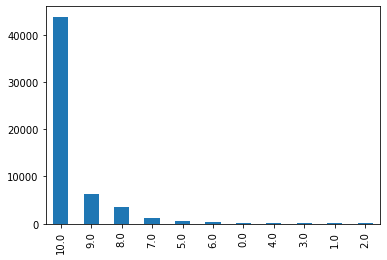

In [10]:
# Visualize SCORE distribution, total 11 scores, majority SCORE = 10
df_train['SCORE'].value_counts().plot(kind = 'bar')

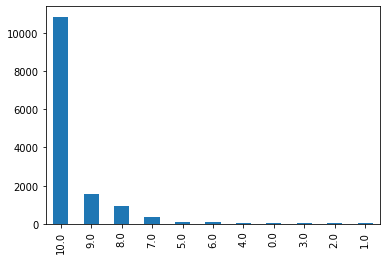

In [11]:
df_validate['SCORE'].value_counts().plot(kind = 'bar')

In [12]:
df_train.isnull().sum()

DOCUMENT_ID            0
SENTENCE_ID            0
SENTENCE              21
SENTENCE_START_POS     0
SENTENCE_END_POS       0
SCORE                  0
dtype: int64

In [13]:
#Remove the missing data 
df_train = df_train.dropna()

In [14]:
df_train.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              0
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 0
dtype: int64

In [15]:
df_train.shape

(56623, 6)

In [16]:
df_validate.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              4
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 1
dtype: int64

In [17]:
df_validate = df_validate.dropna()

In [18]:
df_validate.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              0
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 0
dtype: int64

In [19]:
df_validate.shape

(14014, 6)

## Preprocess Sentences

In [20]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [21]:
# Define preprocess function, remove stop words and punctuations etc.
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))
punc = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    wordList = text.split()
    wordList = ["".join(x for x in word if (x=="'")|(x not in punc)) for word in wordList]
    wordList = [word for word in wordList if word not in stop]
    wordList = [lemma.lemmatize(word) for word in wordList]
    return " ".join(wordList)
clean_text("I Thank you!")

'thank'

In [22]:
# Clean train dataset
df_train["SENTENCE"] = df_train["SENTENCE"].astype("str")
df_train["clean_text"] = df_train["SENTENCE"].apply(clean_text)

In [23]:
# Clean validate dataset
df_validate["SENTENCE"] = df_validate["SENTENCE"].astype("str")
df_validate["clean_text"] = df_validate["SENTENCE"].apply(clean_text)

In [24]:
df_train.head()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE,clean_text
0,583306034,1888104,The whole process went smooth and I am thankfu...,109,165,10.0,whole process went smooth thankful
1,583306034,1888102,It was quick and easy to apply and got the app...,0,60,10.0,quick easy apply got approval quickly
2,584193040,1909902,service,0,7,10.0,service
3,584203035,1910310,Thanks!,198,205,10.0,thanks
4,584200037,1910006,Thank you!,58,68,10.0,thank


In [ ]:
#save cleaned data to Google drive
#df_train.to_csv(path_or_buf='/content/drive/My Drive/Data_Sets/NLP_train.csv')
#df_validate.to_csv(path_or_buf='/content/drive/My Drive/Data_Sets/NLP_validate.csv')

In [ ]:
#upload the cleaned data
#df_train = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_train.csv')
#df_validation = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_validate.csv')

## Random Forest Prediction
### Using word2vec embedding Vectorizer
### Training accuracy much improved than Neural Network LSTM/GRU; Validation accuracy is similar.

In [25]:
xtrain = df_train['clean_text']
ytrain = df_train['SCORE']
xtest = df_validate['clean_text']
ytest = df_validate['SCORE']

In [26]:
!pip install -U zeugma 

  Created wheel for zeugma: filename=zeugma-0.49-py3-none-any.whl size=8821 sha256=d98a38e3381e890ed98807f2200f2f3b37f0433e0cf17ca85a3b5b499f0b1305
  Stored in directory: /root/.cache/pip/wheels/1d/47/5b/2a59a79706cc9340c72fd6a7bfc20e7ebcab849c88c38fdfa0
Successfully built zeugma


In [28]:
from zeugma.embeddings import EmbeddingTransformer

## Available models are fasttext-wiki-news-subwords-300, conceptnet-numberbatch-17-06-300, word2vec-ruscorpora-300, word2vec-google-news-300, glove-wiki-gigaword-50, glove-wiki-gigaword-100, glove-wiki-gigaword-200, glove-wiki-gigaword-300, glove-twitter-25, glove-twitter-50, glove-twitter-100, glove-twitter-200, __testing_word2vec-matrix-synopsis'

In [30]:
#from gensim.models.word2vec import Word2Vec
#import gensim.downloader as api

In [38]:
from gensim.models.word2vec import Word2Vec
#model = Word2Vec(corpus)

In [40]:
word2vec = EmbeddingTransformer('Word2vec')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# download the model and return as object ready for use
#glove_twitter_50 = api.load("glove-twitter-50")

In [ ]:
#glove = EmbeddingTransformer('glove')
#glove = EmbeddingTransformer('glove_twitter_50')

In [41]:
xtrain = word2vec.transform(xtrain)

In [42]:
xtest = word2vec.transform(xtest)

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=50)

rf.fit(xtrain,ytrain)

RandomForestClassifier(n_estimators=50)

### Training Classification_report, Accuracy, 

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       227
         1.0       0.96      0.90      0.93        83
         2.0       1.00      0.82      0.90        79
         3.0       0.97      0.89      0.93       127
         4.0       0.97      0.91      0.94       192
         5.0       0.96      0.84      0.90       516
         6.0       0.96      0.80      0.88       433
         7.0       0.93      0.71      0.80      1297
         8.0       0.92      0.62      0.74      3625
         9.0       0.96      0.55      0.70      6212
        10.0       0.91      1.00      0.95     43832

    accuracy                           0.91     56623
   macro avg       0.96      0.81      0.87     56623
weighted avg       0.91      0.91      0.90     56623

0.9121381770658566


In [46]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[  207     0     0     0     0     0     1     2     8     0     9]
 [    0    75     0     1     0     0     0     0     1     1     5]
 [    0     1    65     1     1     0     0     0     4     2     5]
 [    2     1     0   113     0     0     0     0     6     0     5]
 [    0     0     0     0   174     0     0     1     6     1    10]
 [    2     0     0     0     1   433     2     5    31     3    39]
 [    1     0     0     1     1     1   348     4    20     4    53]
 [    1     0     0     0     1     6     2   918    51     8   310]
 [    0     0     0     0     0     3     3    23  2255    23  1318]
 [    0     1     0     0     0     4     1    13    32  3425  2736]
 [    0     0     0     0     1     3     4    22    49   118 43635]]


### Validation Classification Report, Accuracy

In [47]:
ypred=rf.predict(xtest)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        35
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        20
         3.0       0.00      0.00      0.00        26
         4.0       0.00      0.00      0.00        46
         5.0       0.14      0.01      0.02       111
         6.0       0.00      0.00      0.00        97
         7.0       0.28      0.04      0.06       332
         8.0       0.25      0.04      0.07       904
         9.0       0.19      0.02      0.04      1562
        10.0       0.78      0.98      0.87     10864

    accuracy                           0.77     14014
   macro avg       0.15      0.10      0.10     14014
weighted avg       0.65      0.77      0.69     14014

0.7684458398744113


In [48]:
cm = confusion_matrix(ytest,ypred)
print(cm)

[[    0     0     0     0     0     0     0     0     8     0    27]
 [    0     0     0     0     0     0     0     0     2     0    15]
 [    0     0     0     0     0     0     0     0     1     0    19]
 [    0     0     0     0     1     0     0     0     1     0    24]
 [    0     0     0     0     0     0     0     0     0     0    46]
 [    0     0     0     0     1     1     1     1    12     0    95]
 [    2     0     0     0     0     0     0     4    16     2    73]
 [    1     0     0     0     0     1     0    12    14     1   303]
 [    0     0     0     1     0     1     1     9    37    20   835]
 [    0     1     0     0     0     2     0     4    13    31  1511]
 [    0     1     1     0     0     2     2    13    46   111 10688]]


## Classify SCOREs to 3 Classes
### Not improve the performance

In [3]:
#upload the cleaned data
import pandas as pd
df_train = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_train.csv')
df_validate = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_validate.csv')

In [13]:
df_train['class'] = df_train['SCORE'].apply(lambda x: 0.0 if x<9.0 else(1.0 if x==9.0 else 2.0))
df_validate['class'] = df_train['SCORE'].apply(lambda x: 0.0 if x<9.0 else(1.0 if x==9.0 else 2.0))

In [14]:
df_train.head()

,Unnamed: 0,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE,clean_text,class
0,0,583306034,1888104,The whole process went smooth and I am thankfu...,109,165,10.0,whole process went smooth thankful,2.0
1,1,583306034,1888102,It was quick and easy to apply and got the app...,0,60,10.0,quick easy apply got approval quickly,2.0
2,2,584193040,1909902,service,0,7,10.0,service,2.0
3,3,584203035,1910310,Thanks!,198,205,10.0,thanks,2.0
4,4,584200037,1910006,Thank you!,58,68,10.0,thank,2.0


In [15]:
df_train['class'].value_counts()

2.0    43832
0.0     6579
1.0     6212
Name: class, dtype: int64

In [16]:
df_validate['class'].value_counts()

2.0    10693
0.0     1769
1.0     1552
Name: class, dtype: int64

In [21]:
df_train.isnull().sum()

Unnamed: 0             0
DOCUMENT_ID            0
SENTENCE_ID            0
SENTENCE               0
SENTENCE_START_POS     0
SENTENCE_END_POS       0
SCORE                  0
clean_text            85
class                  0
dtype: int64

In [22]:
df_train = df_train.dropna()

In [23]:
df_validate.isnull().sum()

Unnamed: 0             0
DOCUMENT_ID            0
SENTENCE_ID            0
SENTENCE               0
SENTENCE_START_POS     0
SENTENCE_END_POS       0
SCORE                  0
clean_text            25
class                  0
dtype: int64

In [24]:
df_validate = df_validate.dropna()

In [25]:
xtrain = df_train['clean_text']
ytrain = df_train['class']
xtest = df_validate['clean_text']
ytest = df_validate['class']

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,f_classif, mutual_info_classif

In [26]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
xtrain_vectorized = vectorizer.fit_transform(xtrain)
xtest_vectorized=vectorizer.transform(xtest)

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=50)

rf.fit(xtrain_vectorized,ytrain)

RandomForestClassifier(n_estimators=50)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain_vectorized)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83      6564
         1.0       0.96      0.54      0.69      6204
         2.0       0.91      1.00      0.95     43770

    accuracy                           0.91     56538
   macro avg       0.94      0.75      0.82     56538
weighted avg       0.92      0.91      0.91     56538

0.9139870529555343


In [29]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[ 4779    34  1751]
 [   64  3342  2798]
 [  113   103 43554]]


In [30]:
ypred=rf.predict(xtest_vectorized)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.10      0.04      0.05      1765
         1.0       0.11      0.01      0.03      1550
         2.0       0.76      0.94      0.84     10674

    accuracy                           0.72     13989
   macro avg       0.33      0.33      0.31     13989
weighted avg       0.61      0.72      0.65     13989

0.7220673386232039


In [31]:
cm = confusion_matrix(ytest,ypred)
print(cm)

[[   66    16  1683]
 [   66    22  1462]
 [  503   158 10013]]


## With SMOTE technique for minority classes
### Default strategy of SMOTE to oversample all classes to the number of examples in the majority class

In [2]:
#upload the cleaned data
import pandas as pd
df_train = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_train.csv')
df_validate = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_validate.csv')

In [3]:
df_train.isnull().sum()

Unnamed: 0             0
DOCUMENT_ID            0
SENTENCE_ID            0
SENTENCE               0
SENTENCE_START_POS     0
SENTENCE_END_POS       0
SCORE                  0
clean_text            85
dtype: int64

In [4]:
df_train = df_train.dropna()

In [5]:
df_validate.isnull().sum()

Unnamed: 0             0
DOCUMENT_ID            0
SENTENCE_ID            0
SENTENCE               0
SENTENCE_START_POS     0
SENTENCE_END_POS       0
SCORE                  0
clean_text            25
dtype: int64

In [6]:
df_validate = df_validate.dropna()

In [7]:
xtrain = df_train['clean_text']
ytrain = df_train['SCORE']
xtest = df_validate['clean_text']
ytest = df_validate['SCORE']

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
xtrain = vectorizer.fit_transform(xtrain)
xtest=vectorizer.transform(xtest)

In [8]:
!pip install imbalanced-learn

In [9]:
from imblearn.over_sampling import SMOTE

In [13]:
oversample = SMOTE()
xtrain, ytrain = oversample.fit_resample(xtrain, ytrain)


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=50)

rf.fit(xtrain,ytrain)

RandomForestClassifier(n_estimators=50)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     43770
         1.0       1.00      1.00      1.00     43770
         2.0       1.00      1.00      1.00     43770
         3.0       1.00      0.98      0.99     43770
         4.0       1.00      0.99      0.99     43770
         5.0       0.93      0.97      0.95     43770
         6.0       0.92      0.97      0.95     43770
         7.0       0.94      0.89      0.92     43770
         8.0       0.88      0.83      0.85     43770
         9.0       0.76      0.87      0.81     43770
        10.0       0.87      0.80      0.84     43770

    accuracy                           0.94    481470
   macro avg       0.94      0.94      0.94    481470
weighted avg       0.94      0.94      0.94    481470

0.9352732257461525


In [16]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[43499     0     0     1     0     3   258     2     1     1     5]
 [    1 43764     0     1     0     0     1     0     0     0     3]
 [    0     1 43754     0     1     3     3     1     4     1     2]
 [    5     3     1 42965     0   790     2     0     1     1     2]
 [    0     0     4     0 43131    90   533     3     4     0     5]
 [   34     0     1     0     1 42631  1008    37    35     6    17]
 [    3     0     0     2     3  1131 42467    43    93    12    16]
 [    3     0     0     0     4   838   793 39078   633  1758   663]
 [   32     0     0     0     2   311   546   911 36116  4319  1533]
 [   13     1     1     0     1    11   238   661  2127 37884  2833]
 [    4     1     1     0     0    23   208   683  1892  5941 35017]]


In [17]:
ypred=rf.predict(xtest)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.03      0.06      0.04        35
         1.0       0.00      0.00      0.00        17
         2.0       0.29      0.10      0.15        20
         3.0       0.04      0.08      0.05        26
         4.0       0.00      0.00      0.00        46
         5.0       0.06      0.11      0.07       111
         6.0       0.02      0.07      0.03        96
         7.0       0.06      0.10      0.08       331
         8.0       0.13      0.15      0.14       900
         9.0       0.13      0.21      0.16      1560
        10.0       0.82      0.68      0.74     10847

    accuracy                           0.57     13989
   macro avg       0.14      0.14      0.13     13989
weighted avg       0.66      0.57      0.61     13989

0.5673743655729502


In [18]:
cm = confusion_matrix(ytest,ypred)
print(cm)

[[   2    0    0    1    2    5    3    4    1    1   16]
 [   0    0    0    0    2    1    0    1    5    1    7]
 [   1    0    2    0    0    2    2    2    1    2    8]
 [   0    0    0    2    2    2    1    3    2    0   14]
 [   5    0    1    1    0    1    1    8    4    3   22]
 [   7    0    0    5    5   12    6    5   12    4   55]
 [   3    0    0    2    5   16    7    8   16    8   31]
 [   4    1    1    1    4   28   19   33   50   36  154]
 [  11    1    0    7   12   31   38   72  138  185  405]
 [  10    1    1    4   13   20   37   60  151  326  937]
 [  35    2    2   25   82   97  231  337  685 1936 7415]]


## SMOTE technique for minority classes
### With custom oversample strategy: SCORE 0-8: oversample to 5000.

In [19]:
xtrain = df_train['clean_text']
ytrain = df_train['SCORE']
xtest = df_validate['clean_text']
ytest = df_validate['SCORE']

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
xtrain1 = vectorizer.fit_transform(xtrain)
xtest1=vectorizer.transform(xtest)

In [22]:
strategy = {0.0:5000, 1.0:5000, 2.0:5000, 3.0:5000, 4.0:5000, 5.0:5000, 6.0:5000, 7.0:5000, 8.0:5000}

In [23]:
oversample = SMOTE(sampling_strategy=strategy)
xtrain1, ytrain = oversample.fit_resample(xtrain1, ytrain)


In [24]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=50)

rf.fit(xtrain1,ytrain)

RandomForestClassifier(n_estimators=50)

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain1)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5000
         1.0       1.00      1.00      1.00      5000
         2.0       1.00      1.00      1.00      5000
         3.0       1.00      0.98      0.99      5000
         4.0       1.00      0.98      0.99      5000
         5.0       0.92      0.96      0.94      5000
         6.0       0.95      0.95      0.95      5000
         7.0       0.97      0.84      0.90      5000
         8.0       0.97      0.64      0.77      5000
         9.0       0.96      0.54      0.69      6204
        10.0       0.89      0.99      0.94     43770

    accuracy                           0.93     94974
   macro avg       0.97      0.90      0.92     94974
weighted avg       0.94      0.93      0.93     94974

0.9323499062901426


In [26]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[ 4955     0     0     0     0     4     2     1     1     0    37]
 [    1  4992     0     2     0     0     0     0     0     1     4]
 [    0     1  4986     1     0     3     1     2     1     0     5]
 [    3     0     0  4876     0   114     2     0     1     0     4]
 [    0     0     1     0  4891    27     2     1     1     0    77]
 [    4     0     0     0     1  4822   100    14     5     1    53]
 [    1     0     0     0     0   137  4737     9     9     2   105]
 [    4     0     0     0     1    82    63  4211    10     4   625]
 [    9     0     0     0     1    39    31    55  3211    20  1634]
 [    4     0     1     0     1     7    12    21    28  3369  2761]
 [    3     1     0     0     1     9    31    43    58   125 43499]]


In [27]:
ypred=rf.predict(xtest1)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.03      0.06      0.04        35
         1.0       0.17      0.06      0.09        17
         2.0       0.22      0.10      0.14        20
         3.0       0.00      0.00      0.00        26
         4.0       0.00      0.00      0.00        46
         5.0       0.08      0.10      0.09       111
         6.0       0.05      0.05      0.05        96
         7.0       0.14      0.08      0.10       331
         8.0       0.25      0.05      0.08       900
         9.0       0.17      0.02      0.04      1560
        10.0       0.80      0.96      0.87     10847

    accuracy                           0.75     13989
   macro avg       0.17      0.13      0.14     13989
weighted avg       0.66      0.75      0.69     13989

0.7527342912288226


In [28]:
cm = confusion_matrix(ytest,ypred)
print(cm)

[[    2     0     0     0     1     5     0     6     2     0    19]
 [    0     1     0     1     1     1     0     1     1     0    11]
 [    1     0     2     1     1     2     0     2     1     0    10]
 [    0     0     1     0     1     2     2     1     0     1    18]
 [    5     0     1     0     0     3     1     1     2     0    33]
 [    8     0     0     4     3    11     5     7     5     0    68]
 [    4     0     0     2     5    14     5     8     6     1    51]
 [    5     2     2     3     5    18    13    26    13     5   239]
 [    7     1     1     6     9    19    20    37    44    25   731]
 [    8     1     1     2     4    12     8    20    15    35  1454]
 [   20     1     1    10    25    50    45    72    85   134 10404]]


## Cost-Sensitive Learning for Multi-Class Classification
### The RandomForestClassifier in scikit-learn supports cost-sensitive learning via the “class_weight” argument.
### By default, the random forest class assigns equal weight to each class.


In [30]:
xtrain = df_train['clean_text']
ytrain = df_train['SCORE']
xtest = df_validate['clean_text']
ytest = df_validate['SCORE']

In [31]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
xtrain = vectorizer.fit_transform(xtrain)
xtest=vectorizer.transform(xtest)

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
weights = {0.0:2.0, 1.0:2.0, 2.0:2.0, 3.0:2.0, 4.0:2.0, 5.0:2.0, 6.0:2.0, 7.0:2.0, 8.0:2.0, 9.0:2.0, 10.0:1.0}
rf = RandomForestClassifier(n_estimators=50, class_weight=weights)


In [34]:
rf.fit(xtrain,ytrain)

RandomForestClassifier(class_weight={0.0: 2.0, 1.0: 2.0, 2.0: 2.0, 3.0: 2.0,
                                     4.0: 2.0, 5.0: 2.0, 6.0: 2.0, 7.0: 2.0,
                                     8.0: 2.0, 9.0: 2.0, 10.0: 1.0},
                       n_estimators=50)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       226
         1.0       0.99      0.89      0.94        82
         2.0       0.97      0.84      0.90        79
         3.0       0.97      0.89      0.93       126
         4.0       0.99      0.87      0.93       191
         5.0       0.95      0.83      0.88       513
         6.0       0.93      0.81      0.87       433
         7.0       0.90      0.71      0.79      1295
         8.0       0.86      0.63      0.73      3619
         9.0       0.90      0.57      0.70      6204
        10.0       0.91      0.99      0.95     43770

    accuracy                           0.91     56538
   macro avg       0.94      0.81      0.87     56538
weighted avg       0.91      0.91      0.90     56538

0.9088577593830698


In [36]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[  204     0     0     0     0     2     1     3     7     0     9]
 [    0    73     0     2     0     0     1     0     1     1     4]
 [    0     1    66     0     0     1     0     2     4     0     5]
 [    2     0     1   112     0     0     0     0     7     0     4]
 [    0     0     0     0   166     3     1     3     4     2    12]
 [    0     0     0     0     0   425     2    11    35     5    35]
 [    1     0     0     1     0     1   352     5    32     3    38]
 [    1     0     0     0     0     4     4   923    60    12   291]
 [    0     0     0     0     0     6     3    28  2297    31  1254]
 [    1     0     1     0     0     2     3    17    51  3536  2593]
 [    0     0     0     0     1     5    11    39   158   325 43231]]


In [37]:
ypred=rf.predict(xtest)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.12      0.03      0.05        35
         1.0       0.00      0.00      0.00        17
         2.0       0.17      0.05      0.08        20
         3.0       0.00      0.00      0.00        26
         4.0       0.00      0.00      0.00        46
         5.0       0.10      0.02      0.03       111
         6.0       0.07      0.01      0.02        96
         7.0       0.18      0.04      0.06       331
         8.0       0.25      0.08      0.12       900
         9.0       0.17      0.03      0.05      1560
        10.0       0.79      0.97      0.87     10847

    accuracy                           0.76     13989
   macro avg       0.17      0.11      0.12     13989
weighted avg       0.65      0.76      0.69     13989

0.7621702766459361


In [38]:
cm = confusion_matrix(ytest,ypred)
print(cm)

[[    1     0     0     0     0     0     0     3     6     0    25]
 [    0     0     0     0     0     0     1     0     3     0    13]
 [    1     0     1     0     0     0     0     2     1     0    15]
 [    0     0     0     0     0     2     0     1     1     0    22]
 [    1     0     0     0     0     0     0     0     2     0    43]
 [    1     0     0     1     0     2     0     2    16     1    88]
 [    2     0     0     1     1     1     1     7    21     3    59]
 [    1     1     1     1     0     5     2    13    28     8   271]
 [    0     1     1     1     0     5     3    16    68    40   765]
 [    0     0     1     1     0     2     0    11    25    48  1472]
 [    1     1     2     0     1     3     7    16    98   190 10528]]


## Undersampling by Using NearMiss Algorithm


In [ ]:
xtrain = df_balance['clean_text']
ytrain = df_balance['SCORE']
xtest = df_validate['clean_text']
ytest = df_validate['SCORE']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
xtrain_vectorized = vectorizer.fit_transform(xtrain)
xtest_vectorized=vectorizer.transform(xtest)

### Evaluation the Train dataset

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain_vectorized)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

In [ ]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

In [ ]:
ypred=rf.predict(xtest_vectorized)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

In [ ]:
cm1 = (confusion_matrix(ytest,ypred))
print(cm1)

# Summary and Improvement:

## 1. Using Random Forest with pre-trained word2vec embedding vectorizer, the train acc reached 0.91 and test acc reached 0.77.
## 2. Using SMOTE oversampling with custom strategy, train acc increased to 0.94, validation acc 0.75.
## 3. Cost-Sensitive Learning for Multi-Class Classification didn't improve the performance: train acc 0.91, validation acc 0.76.
## Improvement:      
## 1. Undersampling: Try NearMiss technique, which remove majority samples near to minority samples.
## 2. Understand the domain knowledge of dataset, which may help the data preprocessing.
